In [7]:
#Hunter Ma 2023/5 studying in SEU
#以下内容为jupyter notebook内容的合并，我会发布另一个notebook的版本，所以建议拿这个缝合版一步一步运行

#Importing the basic librarires
#import 基本的包，后面用到再说
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

#warnings这个包比较有意思，我的理解是他会过滤掉很多因python版本不兼容而现实的复杂但不必要的报错提醒，引入下面的这个函数就会屏蔽掉这些内容
import warnings 
warnings.filterwarnings('ignore')



In [8]:
#pd.read_csv()函数读取一个CSV文件并将其转换成一个DataFrame对象df，至于什么是DataFrame对象，这个可以自行百度(非常简单)
df = pd.read_csv('../song_data.csv')

#df.drop()删除了数据的一列，该列的名称为'song_name'，axis=1代表是列，inplace=True代表删除操作是在原数据上进行的
df.drop(['song_name'], axis=1, inplace=True)

#display顾名思义， .head()为dataframe结构的函数，展示该数据的前五行内容
display(df.head())



,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [9]:
#将我们需要拟合的label拿出并赋值target
target = 'song_popularity'

#将除了target外的特征赋值存入features
features = [i for i in df.columns if i not in [target]]



In [10]:
#df的原拷贝，便于后续处理，deep=True意味着拷贝df中的全部内容：它与原始数据df具有相同的数据结构和内容，
# 但是在内存中存储的位置不同，即它们是两个独立的对象。同时，由于使用了deep=True参数，所以在创建original_df对象时，
# 它的所有数据和索引都被完整复制了一份，而不是只复制一个对原始数据的引用。这样做的目的通常是为了避免在对original_df进行操作时，
# 对原始数据df造成影响。这在数据处理和机器学习任务中非常重要，因为在处理数据时，我们往往需要多次尝试不同的方法和算法，
# 而避免修改原始数据可以确保数据的完整性和可重复性。
original_df = df.copy(deep=True)

#print上述的一些信息，这里的{}对应后面的.format内容，即{}内的内容为df.shape[1], df.shape[0]，可以立即为完形填空
print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))




Inference: The Datset consists of 14 features & 18835 samples.


In [11]:
#.info()函数，查看df的具体信息，如包含的数据量，每行每列数据的类型(dtype)等等
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


In [12]:
#.unique()函数返回每个特征中唯一值的数量，而sort_values()函数则将这些值按照从小到大的顺序排序。
#由于nunique()方法返回的是一个Series对象，因此可以直接使用sort_values()方法对其进行排序。
# 最终输出的结果是一个包含数据集中每个特征唯一值数量的Series对象，其中索引是特征名，值是唯一值数量。
# 这可以帮助我们快速了解数据集中每个特征的分布情况，从而为后续的数据分析和建模工作提供参考。
df.nunique().sort_values()

#首先计算数据集df中除目标变量外的每个特征的唯一值数量，并将结果按照从小到大的顺序排序。
nu = df[features].nunique().sort_values()

#nf,数值特征：cf，分类特征
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

#接着，代码遍历所有特征，将唯一值数量小于等于16的特征视为分类特征，将唯一值数量大于16的特征视为数值特征。
for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

#打印inference，具体同上述内容
print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))

#df.describe()函数用于查询df的具体统计特征，如总和，平均值，标准差等...
display(df.describe())




Inference: The Datset has 10 numerical & 3 categorical features.


,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,18835.000000,1.883500e+04,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000
mean,52.991877,2.182116e+05,0.258539,0.633348,0.644995,0.078008,5.289196,0.179650,-7.447435,0.628139,0.102099,121.073154,3.959119,0.527967
std,21.905654,5.988754e+04,0.288719,0.156723,0.214101,0.221591,3.614595,0.143984,3.827831,0.483314,0.104378,28.714456,0.298533,0.244632
min,0.000000,1.200000e+04,0.000001,0.000000,0.001070,0.000000,0.000000,0.010900,-38.768000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,1.843395e+05,0.024100,0.533000,0.510000,0.000000,2.000000,0.092900,-9.044000,0.000000,0.037800,98.368000,4.000000,0.335000
50%,56.000000,2.113060e+05,0.132000,0.645000,0.674000,0.000011,5.000000,0.122000,-6.555000,1.000000,0.055500,120.013000,4.000000,0.527000
75%,69.000000,2.428440e+05,0.424000,0.748000,0.815000,0.002570,8.000000,0.221000,-4.908000,1.000000,0.119000,139.931000,4.000000,0.725000
max,100.000000,1.799346e+06,0.996000,0.987000,0.999000,0.997000,11.000000,0.986000,1.585000,1.000000,0.941000,242.318000,5.000000,0.984000


In [13]:
#首先计算数据集df中除目标变量外的每个特征的唯一值数量，并将结果按照从小到大的顺序排序。
nu = df[features].nunique().sort_values()

#nf,数值特征：cf，分类特征
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

#接着，代码遍历所有特征，将唯一值数量小于等于16的特征视为分类特征，将唯一值数量大于16的特征视为数值特征。
for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

#打印inference，具体同上述内容
print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))

#df.describe()函数用于查询df的具体统计特征，如总和，平均值，标准差等...
display(df.describe())




Inference: The Datset has 10 numerical & 3 categorical features.


,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,18835.000000,1.883500e+04,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000
mean,52.991877,2.182116e+05,0.258539,0.633348,0.644995,0.078008,5.289196,0.179650,-7.447435,0.628139,0.102099,121.073154,3.959119,0.527967
std,21.905654,5.988754e+04,0.288719,0.156723,0.214101,0.221591,3.614595,0.143984,3.827831,0.483314,0.104378,28.714456,0.298533,0.244632
min,0.000000,1.200000e+04,0.000001,0.000000,0.001070,0.000000,0.000000,0.010900,-38.768000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,1.843395e+05,0.024100,0.533000,0.510000,0.000000,2.000000,0.092900,-9.044000,0.000000,0.037800,98.368000,4.000000,0.335000
50%,56.000000,2.113060e+05,0.132000,0.645000,0.674000,0.000011,5.000000,0.122000,-6.555000,1.000000,0.055500,120.013000,4.000000,0.527000
75%,69.000000,2.428440e+05,0.424000,0.748000,0.815000,0.002570,8.000000,0.221000,-4.908000,1.000000,0.119000,139.931000,4.000000,0.725000
max,100.000000,1.799346e+06,0.996000,0.987000,0.999000,0.997000,11.000000,0.986000,1.585000,1.000000,0.941000,242.318000,5.000000,0.984000


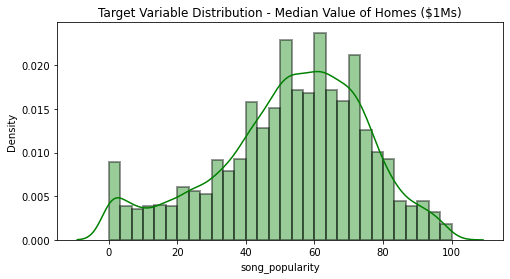

In [14]:
#设施figure大小
plt.figure(figsize=[8,4])

#这段代码使用了Seaborn库的distplot()方法绘制了目标变量的分布直方图。具体来说，代码传入了以下参数：
#df[target]：指定目标变量的数据；
#color='g'：设置直方图的颜色为绿色；
#hist_kws=dict(edgecolor="black", linewidth=2)：设置直方图的边界颜色为黑色，宽度为2；
#bins=30：设置直方图的箱数为30
#distplot()方法会绘制数据的直方图，并且可以根据需要添加核密度估计图和拟合参数分布等
#在这段代码中，由于只传入了目标变量的数据，因此只绘制了目标变量的分布直方图。
#绘制分布直方图可以帮助我们了解目标变量的分布情况，例如是否呈现正态分布、是否存在偏度、峰度等
#这些信息可以帮助我们更好地选择合适的模型和算法，并进行后续的数据处理和特征工程
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                               Visualising Categorical Features:                                


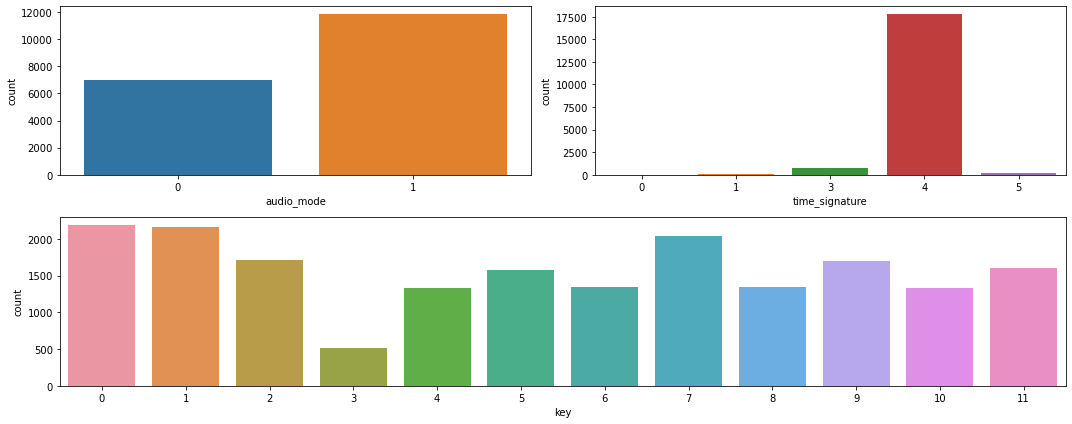

In [15]:
#Visualising the categorical features 
print('\033[1mVisualising Categorical Features:'.center(100))

#置画布的大小为[15, 3*math.ceil(len(cf)/n)]
#其中math.ceil(len(cf)/n)表示按照每行最多2个特征的要求，需要多少行才能展示所有的分类特征
n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

#箱型图（Box Plot）是一种用于展示数据分布情况的图表，常用于探索性数据分析（Exploratory Data Analysis, EDA）中
#它主要展示数据的中位数、四分位数、异常值等信息，有助于我们了解数据的集中趋势和离散程度
#以下用于展示cf的分布
for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(2,1,2)
        sns.countplot(df[cf[i]])
#绘图
plt.tight_layout()
plt.show()

                                 Numeric Features Distribution                                  


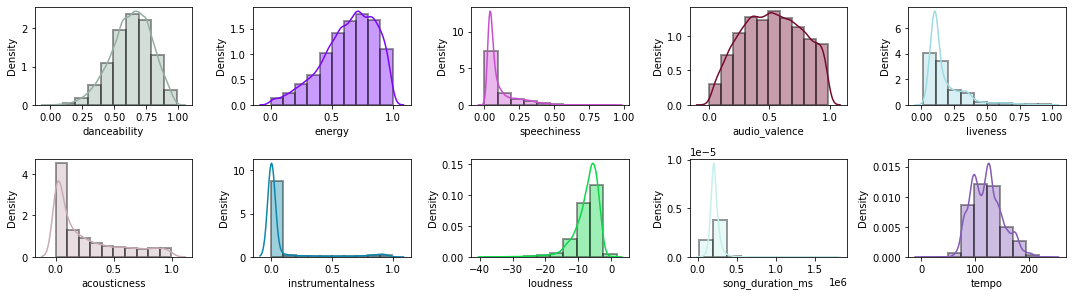

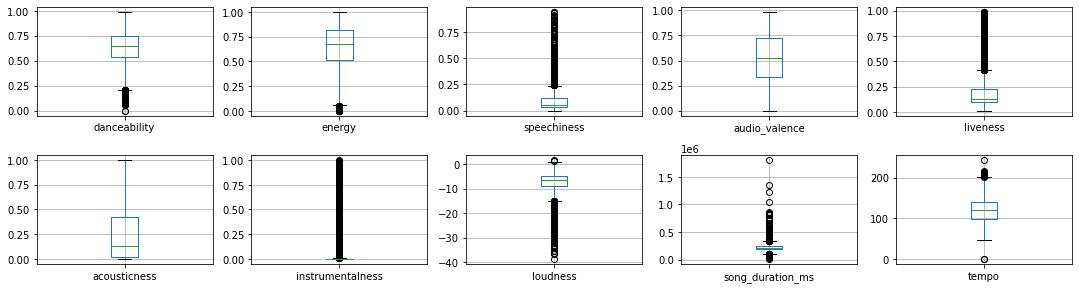

In [16]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(100))

#以下用于展示nf的分布，细节同上
n=5
clr=['r','g','b','g','b','r']
plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

In [ ]:
#Understanding the relationship between all the features
#这段代码生成了一个散点图矩阵（Scatterplot Matrix），也称为Pairplot
#Pairplot是一种数据可视化技术，用于同时展示多个特征之间的两两关系
#在这段代码中，首先使用Seaborn库的pairplot函数生成了一个散点图矩阵
#散点图矩阵中，每个特征都会和其他特征两两配对，从而得到多个二维散点图
#接着，使用map_upper函数在每个二维散点图上绘制了核密度估计图（Kernel Density Estimation, KDE）用来展示每个特征的分布情况
#最后，使用plt.title函数给整个散点图矩阵添加了一个标题
#通过这个散点图矩阵，我们可以直观地观察不同特征之间的关系，比如是否存在线性相关性、是否存在异常值等等
#同时，我们也可以通过观察每个特征的分布情况，了解其是否符合正态分布或者其他特殊分布。
g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()